In [26]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime
from textwrap import wrap
from datenspende_who5 import styling, colors

In [19]:
wording = {
    49: 'In the last four weeks, I have been happy and in good spirits.',
    50: '... I have felt calm and relaxed.',
    54: '... I have felt energetic and active.',
    55: '... I have felt fresh and rested when I wake up.',
    56: '... my daily life has been full of things that interest me.',
    'total_wellbeing': 'Average wellbeing'
}

In [53]:
def load_df():
    
    df = pd.read_feather('../data/01_raw/who5_responses.feather')
    df['date'] = pd.to_datetime(df.created_at, unit='ms').dt.date
    return df

def aggregate(df, question):
    
    df = df[df.question == question].groupby('date', as_index=False).agg({'choice_id': ['mean', 'std', 'count']})
    df.rename(columns={'': 'date'}, inplace=True)
    
    df = df.droplevel(axis=1, level=0)
    df['err'] = df['std'] / np.sqrt(df['count'])
    
    df.dropna(inplace=True)
    df = df.sort_values(by='date')
    df = df[df.date >= datetime.date(2021, 11, 1)]
    
    return df

def average_wellbeing(df):
    
    total = df.groupby(['user_id', 'date'], as_index=False).agg({'choice_id': ['mean', 'count']})
    total.drop(columns=['user_id'], level=0, inplace=True)
    total = total.droplevel(axis=1, level=0)
    total.rename(columns={'': 'date', 'mean': 'choice_id'}, inplace=True)
    total = total[total['count'] == 5]
    total.drop(columns=['count'], inplace=True)
    total['question'] = 0
    
    return total

def plot_average_and_individual_questions():
    
    answers = load_df()

    f, axarr = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(7, 8))

    total = average_wellbeing(answers)
    agg = aggregate(total, 0)

    ax = axarr[0, 0]
    ax.plot(agg.date, agg['mean'], lw=1, c=colors.flatuicolors.wetasphalt)
    ax.fill_between(agg.date, agg['mean']-1.96*agg['err'], agg['mean']+1.96*agg['err'], alpha=0.3, color=colors.flatuicolors.wetasphalt)
    ax.set_title(wording['total_wellbeing'])

    for ax, question in zip(axarr.flatten()[1:], [49, 50, 54, 55, 56]):

        df = aggregate(answers, question)
        ax.plot(df.date, df['mean'], lw=1, c=colors.flatuicolors.wetasphalt)
        ax.fill_between(df.date, df['mean']-1.96*df['err'], df['mean']+1.96*df['err'], alpha=0.3, color=colors.flatuicolors.wetasphalt)

        #ax.plot(agg.date, agg['mean'], lw=1, c='k', ls='-', alpha=0.5, label=wording['total_wellbeing'])

        title = wording[question] #answers[answers.question == question].description.values[0]
        title = '\n'.join(wrap(title, 35))
        ax.set_title(title)

    for ax in axarr.flatten():
        styling.hide_and_move_axis(ax)

    for ax in axarr[2]:
        for label in ax.get_xticklabels():
            label.set_ha("right")
            label.set_rotation(45)

    #axarr[0, 1].legend()
    plt.tight_layout()
    
    plt.savefig('../output/1.01-average_survey_responses.jpg', dpi=400)

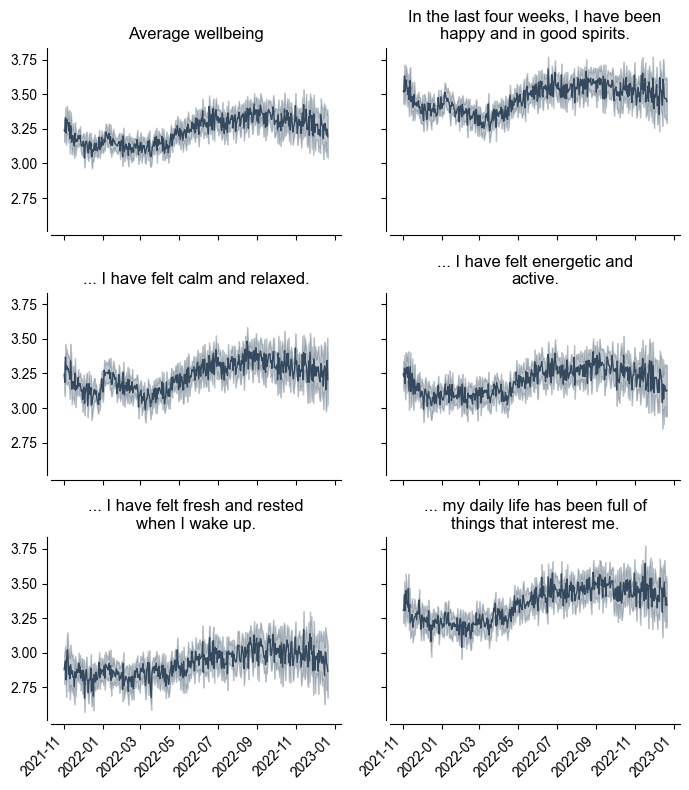

In [54]:
plot_average_and_individual_questions()